## **IMPORT LIBRARY**

In [1]:
# IMPORT LIBRARIES

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import make_scorer
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost.sklearn import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_validate, cross_val_predict, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as Pipeline

from imblearn.over_sampling import SMOTE, SMOTENC

# Ignore Warnings
import sys
import warnings
warnings.filterwarnings('ignore')
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
import pickle

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

import matplotlib.pyplot as plt

In [139]:
# Read Files

df_aac = pd.read_excel("CleanYamanishi/enzyme_PAAC.xlsx", index_col=[0])
df_ctd = pd.read_excel("CleanYamanishi/enzyme_CTD.xlsx", index_col=[0])
df_pssm = pd.read_excel("CleanYamanishi/enzyme_pssm_clean.xlsx", index_col=[0])
df_dpc = pd.read_excel("CleanYamanishi/enzyme_DPC.xlsx", index_col=[0])
df_com = pd.read_excel("CleanYamanishi/enzyme_drug_clean.xlsx", index_col=[0])
df_full = pd.read_excel("enzyme_dataset_x3.xlsx", index_col=[0])

In [147]:
df_com

,PUBCHEM_1,PUBCHEM_2,PUBCHEM_3,PUBCHEM_4,PUBCHEM_5,PUBCHEM_6,PUBCHEM_7,PUBCHEM_8,PUBCHEM_9,PUBCHEM_10,...,PUBCHEM_873,PUBCHEM_874,PUBCHEM_875,PUBCHEM_876,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881,DRUG
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00002
1,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00448
2,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00037
3,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00155
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00709
441,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D01256
442,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D02441
443,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,D00537


In [140]:
df_full.rename(columns={'DRUG': 'PROT', 'PROT': 'DRUG'}, inplace=True)

In [148]:
# FEATURE RENAME

df_pssm_name = df_pssm['PROT']
df_pssm = df_pssm.drop(['PROT'], axis=1)
df_pssm.columns = [f'PSSM_{i+1}' for i in range(len(df_pssm.columns))]
df_pssm["PROT"] = df_pssm_name
df_pssm

df_com_name = df_com['DRUG']
df_com = df_com.drop(['DRUG'], axis=1)
df_com.columns = [f'PUBCHEM_{i+1}' for i in range(len(df_com.columns))]
df_com["DRUG"] = df_com_name
df_com

df_dpc.columns = [f'DPC_{i+1}' for i in range(len(df_dpc.columns))]
df_dpc.columns = [*df_dpc.columns[:-1], 'PROT']

# df_aac.columns = [f'AAC_{i+1}' for i in range(len(df_aac.columns))]
# df_aac.columns = [*df_aac.columns[:-1], 'PROT']

df_aac_name = df_aac['PROTEIN_NAME']
df_aac = df_aac.drop(['PROTEIN_NAME'], axis=1)
df_aac.columns = [f'PAAC_{i+1}' for i in range(len(df_aac.columns))]
df_aac["PROT"] = df_aac_name
df_aac

df_ctd.columns = [f'CTD_{i+1}' for i in range(len(df_ctd.columns))]
df_ctd.columns = [*df_ctd.columns[:-1], 'PROT']

In [149]:
df_merged_full = pd.merge(df_full, df_com, on="DRUG")
df_merged_full

,PROT,DRUG,class,PUBCHEM_1,PUBCHEM_2,PUBCHEM_3,PUBCHEM_4,PUBCHEM_5,PUBCHEM_6,PUBCHEM_7,...,PUBCHEM_872,PUBCHEM_873,PUBCHEM_874,PUBCHEM_875,PUBCHEM_876,PUBCHEM_877,PUBCHEM_878,PUBCHEM_879,PUBCHEM_880,PUBCHEM_881
0,hsa:10,D00002,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,hsa:107,D00002,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,hsa:108,D00002,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,hsa:109,D00002,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,hsa:111,D00002,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11699,hsa:51727,D00496,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11700,hsa:5146,D00496,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11701,hsa:11266,D00496,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11702,hsa:2043,D00496,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [150]:
df_full_paac = pd.merge(df_merged_full, df_aac, on="PROT")
df_full_ctd = pd.merge(df_merged_full, df_ctd, on="PROT")
df_full_pssm = pd.merge(df_merged_full, df_pssm, on="PROT")
df_full_dpc = pd.merge(df_merged_full, df_dpc, on="PROT")

df_full_all = pd.merge(df_full_paac, df_ctd, on="PROT")
df_full_all = pd.merge(df_full_all, df_pssm, on="PROT")
df_full_all = pd.merge(df_full_all, df_dpc, on="PROT")

In [151]:
X_paac = df_full_paac.drop(['class', 'PROT', 'DRUG'], axis=1)
y_paac = df_full_paac[['class']]

X_ctd = df_full_ctd.drop(['class', 'PROT', 'DRUG'], axis=1)
y_ctd = df_full_ctd[['class']]

X_pssm = df_full_pssm.drop(['class', 'PROT', 'DRUG'], axis=1)
y_pssm = df_full_pssm[['class']]

X_dpc = df_full_dpc.drop(['class', 'PROT', 'DRUG'], axis=1)
y_dpc = df_full_dpc[['class']]

X_all = df_full_all.drop(['class', 'PROT', 'DRUG'], axis=1)
y_all = df_full_all[['class']]

# LASSO

In [152]:
#Init
transformer_paac = ColumnTransformer([
    ('scaler', StandardScaler(), [var for var in X_paac.columns]),
], remainder='passthrough')

transformer_ctd = ColumnTransformer([
    ('scaler', StandardScaler(), [var for var in X_ctd.columns]),
], remainder='passthrough')

transformer_pssm = ColumnTransformer([
    ('scaler', StandardScaler(), [var for var in X_pssm.columns]),
], remainder='passthrough')

transformer_dpc = ColumnTransformer([
    ('scaler', StandardScaler(), [var for var in X_dpc.columns]),
], remainder='passthrough')

transformer_all = ColumnTransformer([
    ('scaler', StandardScaler(), [var for var in X_all.columns]),
], remainder='passthrough')

In [93]:
#CV

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

lasso = Lasso(random_state=42, positive=True)

param_grid_lasso = {'model__alpha':[0.001, 0.0001]}

# GPCR PAAC
lasso_pip_paac = Pipeline([
                     ('scaler', transformer_paac), 
                     ('model', Lasso(positive=True))
                     ])

lasso_sf_paac = GridSearchCV(estimator = lasso_pip_paac,
                      param_grid = param_grid_lasso, 
                      cv = skfold, 
                      scoring = 'neg_mean_absolute_error',
                      verbose = 3)

lasso_sf_paac.fit(X_paac, y_paac)

# GPCR CTD
lasso_pip_ctd = Pipeline([
                     ('scaler', transformer_ctd), 
                     ('model', Lasso(positive=True))
                     ])

lasso_sf_ctd = GridSearchCV(estimator = lasso_pip_ctd,
                      param_grid = param_grid_lasso, 
                      cv = skfold, 
                      scoring = 'neg_mean_absolute_error',
                      verbose = 3)

lasso_sf_ctd.fit(X_ctd, y_ctd)

# GPCR PSSM
lasso_pip_pssm = Pipeline([
                     ('scaler', transformer_pssm), 
                     ('model', Lasso(positive=True))
                     ])

lasso_sf_pssm = GridSearchCV(estimator = lasso_pip_pssm,
                      param_grid = param_grid_lasso, 
                      cv = skfold, 
                      scoring = 'neg_mean_absolute_error',
                      verbose = 3)

lasso_sf_pssm.fit(X_pssm, y_pssm)

# # GPCR DPC
lasso_pip_dpc = Pipeline([
                     ('scaler', transformer_dpc), 
                     ('model', Lasso(positive=True))
                     ])

lasso_sf_dpc = GridSearchCV(estimator = lasso_pip_dpc,
                      param_grid = param_grid_lasso, 
                      cv = skfold, 
                      scoring = 'neg_mean_absolute_error',
                      verbose = 3)

lasso_sf_dpc.fit(X_dpc, y_dpc)

# GPCR ALL
lasso_pip_all = Pipeline([
                     ('scaler', transformer_all), 
                     ('model', Lasso(positive=True))
                     ])

lasso_sf_all = GridSearchCV(estimator = lasso_pip_all,
                      param_grid = param_grid_lasso, 
                      cv = skfold, 
                      scoring = 'neg_mean_absolute_error',
                      verbose = 3)

lasso_sf_all.fit(X_all, y_all)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...............model__alpha=0.001;, score=-0.312 total time=   0.0s
[CV 2/5] END ...............model__alpha=0.001;, score=-0.345 total time=   0.0s
[CV 3/5] END ...............model__alpha=0.001;, score=-0.343 total time=   0.0s
[CV 4/5] END ...............model__alpha=0.001;, score=-0.324 total time=   0.0s
[CV 5/5] END ...............model__alpha=0.001;, score=-0.336 total time=   0.0s
[CV 1/5] END ..............model__alpha=0.0001;, score=-0.306 total time=   0.0s
[CV 2/5] END ..............model__alpha=0.0001;, score=-0.344 total time=   0.0s
[CV 3/5] END ..............model__alpha=0.0001;, score=-0.350 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.0001;, score=-0.324 total time=   0.0s
[CV 5/5] END ..............model__alpha=0.0001;, score=-0.328 total time=   0.0s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5] END ...............model__alpha=0.001;, score=-0.304 total ti

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('scaler',
                                                                         StandardScaler(),
                                                                         ['PUBCHEM_1',
                                                                          'PUBCHEM_2',
                                                                          'PUBCHEM_3',
                                                                          'PUBCHEM_4',
                                                                          'PUBCHEM_5',
                                                                          'PUBCHEM_6',
                                                                          'PUBCHEM_7',
        

In [94]:
print(lasso_sf_paac.best_params_)
print(lasso_sf_ctd.best_params_)
print(lasso_sf_pssm.best_params_)
print(lasso_sf_dpc.best_params_)
print(lasso_sf_all.best_params_)

{'model__alpha': 0.0001}
{'model__alpha': 0.001}
{'model__alpha': 0.0001}
{'model__alpha': 0.001}
{'model__alpha': 0.001}


In [12]:
# lasso_sf_paac

In [153]:
lasso_best = Lasso(alpha=0.001)

X = [X_paac, X_ctd, X_pssm, X_dpc, X_all]
y = [y_paac, y_ctd, y_pssm, y_dpc, y_all]
feature = ['paac', 'ctd', 'pssm', 'dpc', 'all']

for feature, X, y in zip(feature, X, y):
    lasso_best.fit(X, y)
    coef_lassoreg = pd.DataFrame({
        'feature_names':list(X),
        'feature coef':lasso_best.coef_
    })

    if feature == "paac":
        feature_names_paac = coef_lassoreg[coef_lassoreg['feature coef'] != 0]['feature_names']

    elif feature == "ctd":
        feature_names_ctd = coef_lassoreg[coef_lassoreg['feature coef'] != 0]['feature_names']

    elif feature == "pssm":
        feature_names_pssm = coef_lassoreg[coef_lassoreg['feature coef'] != 0]['feature_names']

    elif feature == "dpc":
        feature_names_dpc = coef_lassoreg[coef_lassoreg['feature coef'] != 0]['feature_names']

    else:
        feature_names_all = coef_lassoreg[coef_lassoreg['feature coef'] != 0]['feature_names']

print('Selected feature (GPCR-PAAC): ', len(feature_names_paac))
print('Selected feature (GPCR-CTD): ', len(feature_names_ctd))
print('Selected feature (GPCR-PSSM): ', len(feature_names_pssm))
print('Selected feature (GPCR-DPC): ', len(feature_names_dpc))
print('Selected feature (GPCR-ALL): ', len(feature_names_all))

Selected feature (GPCR-PAAC):  172
Selected feature (GPCR-CTD):  237
Selected feature (GPCR-PSSM):  285
Selected feature (GPCR-DPC):  297
Selected feature (GPCR-ALL):  406


In [154]:
#Feature Selected

feature_selected_paac = [i for i in feature_names_paac]
feature_selected_ctd = [i for i in feature_names_ctd]
feature_selected_pssm = [i for i in feature_names_pssm]
feature_selected_dpc = [i for i in feature_names_dpc]
feature_selected_all = [i for i in feature_names_all]

In [155]:
# X_train

X_paac = X_paac[feature_selected_paac]
X_ctd = X_ctd[feature_selected_ctd]
X_pssm = X_pssm[feature_selected_pssm]
X_dpc = X_dpc[feature_selected_dpc]
X_all = X_all[feature_selected_all]

## **Modelling With Using Feature Selection**

## **Hyperparameter Tuning**

In [156]:
#Init

param_grid_xgb = {
              'clf_xgb__n_estimators':[1000], #, 100, 1000 
              'clf_xgb__max_depth':[8], #6, 4,  
              'clf_xgb__learning_rate':[0.1], #0.2, 0.01
              'clf_xgb__subsample':[0.5],
              'clf_xgb__min_child_weight':[1], #, 4, 8 
              'clf_xgb__colsample_bytree':[0.5], #0.5, 
              'clf_xgb__n_jobs':[-1]}

metrics = ['roc_auc', 'accuracy','f1_macro','precision_macro','recall_macro', 'average_precision']

smote = SMOTE(random_state=42)

xgb = XGBClassifier(random_state=42, verbosity=0, eval_metric='aucpr')
xgb_pip = Pipeline([('resampling', smote), ('clf_xgb', xgb)])

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

##### **PAAC**

In [157]:
#hyperparameter

xgb_clf_paac = GridSearchCV(estimator = xgb_pip,
                      param_grid = param_grid_xgb, 
                      cv = skfold, 
                      scoring = metrics,
                      refit = 'f1_macro',
                      error_score = 'raise', 
                      return_train_score=True,
                      verbose = 3)
                     
xgb_clf_paac.fit(X_paac, y_paac)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.933) average_precision: (train=1.000, test=0.937) f1_macro: (train=1.000, test=0.911) precision_macro: (train=1.000, test=0.911) recall_macro: (train=1.000, test=0.910) roc_auc: (train=1.000, test=0.971) total time=  13.5s
[CV 2/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.920) average_precision: (train=1.000, test=0.907) f1_macro: (train=1.000, test=0.893) precision_macro: (train=1.000, test=0.894) recall_macro: (train=1.000, test=0.891) roc_auc: (train=1.000, test=0.953) total time=  13.5s
[CV 3/5] END clf_xgb__colsample_bytree=0.5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=42)),
                                       ('clf_xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      gamma=None, gpu_id=None,
                                                      impo...
             param_grid={'clf_xgb__colsample_bytree': [0.5],
                         'clf_xg

In [158]:
#save grid search

paac_cv_result = pd.DataFrame(xgb_clf_paac.cv_results_)
paac_cv_result = paac_cv_result[['mean_test_f1_macro','mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro', 'param_clf_xgb__max_depth', 'param_clf_xgb__subsample', 'param_clf_xgb__n_estimators', 'param_clf_xgb__min_child_weight', 'param_clf_xgb__colsample_bytree', 'param_clf_xgb__learning_rate']]
paac_cv_result.sort_values(by=['mean_test_f1_macro', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro'], inplace=True, ascending=False)
# paac_cv_result.to_excel('ic_paac_grid_search_nonLasso.xlsx')
paac_cv_result

,mean_test_f1_macro,mean_test_roc_auc,mean_test_accuracy,mean_test_precision_macro,mean_test_average_precision,mean_test_recall_macro,param_clf_xgb__max_depth,param_clf_xgb__subsample,param_clf_xgb__n_estimators,param_clf_xgb__min_child_weight,param_clf_xgb__colsample_bytree,param_clf_xgb__learning_rate
0,0.899594,0.958342,0.925068,0.901557,0.912499,0.897752,8,0.5,1000,1,0.5,0.1


In [159]:
y_real = []
y_proba = []
for i, (train_index, test_index) in enumerate(skfold.split(X_paac, y_paac)):
    Xtrain, Xtest = X_paac.iloc[train_index], X_paac.iloc[test_index]
    ytrain, ytest = y_paac.iloc[train_index], y_paac.iloc[test_index]
    xgb_pip.fit(Xtrain, ytrain)
    pred_proba = xgb_pip.predict_proba(Xtest)
    y_real.append(ytest)
    y_proba.append(pred_proba[:,1])

y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)

#### GPCR - CTD

In [160]:
#Init

param_grid_xgb = {
              'clf_xgb__n_estimators':[1000], #, 100, 500 
              'clf_xgb__max_depth':[6], #8, 4,  
              'clf_xgb__learning_rate':[0.1], #0.2, 0.01
              'clf_xgb__subsample':[0.5],
              'clf_xgb__min_child_weight':[1], #, 4, 8 
              'clf_xgb__colsample_bytree':[0.5], #0.25, 
              'clf_xgb__n_jobs':[-1]}

metrics = ['roc_auc', 'accuracy','f1_macro','precision_macro','recall_macro', 'average_precision']

smote = SMOTE(random_state=42)

xgb = XGBClassifier(random_state=42, verbosity=0, eval_metric='aucpr')
xgb_pip = Pipeline([('resampling', smote), ('clf_xgb', xgb)])

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [161]:
xgb_clf_ctd = GridSearchCV(estimator = xgb_pip,
                      param_grid = param_grid_xgb, 
                      cv = skfold, 
                      scoring = metrics,
                      refit = 'f1_macro',
                      error_score = 'raise', 
                      return_train_score=True,
                      verbose = 3)
                     
xgb_clf_ctd.fit(X_ctd, y_ctd)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=6, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=0.999, test=0.917) average_precision: (train=1.000, test=0.904) f1_macro: (train=0.999, test=0.888) precision_macro: (train=0.999, test=0.892) recall_macro: (train=0.999, test=0.885) roc_auc: (train=1.000, test=0.956) total time=  14.5s
[CV 2/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=6, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.906) average_precision: (train=1.000, test=0.882) f1_macro: (train=1.000, test=0.873) precision_macro: (train=1.000, test=0.879) recall_macro: (train=1.000, test=0.867) roc_auc: (train=1.000, test=0.937) total time=  14.3s
[CV 3/5] END clf_xgb__colsample_bytree=0.5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=42)),
                                       ('clf_xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      gamma=None, gpu_id=None,
                                                      impo...
             param_grid={'clf_xgb__colsample_bytree': [0.5],
                         'clf_xg

In [162]:
#save grid search

ctd_cv_result = pd.DataFrame(xgb_clf_ctd.cv_results_)
ctd_cv_result = ctd_cv_result[['mean_test_f1_macro','mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro', 'param_clf_xgb__max_depth', 'param_clf_xgb__subsample', 'param_clf_xgb__n_estimators', 'param_clf_xgb__min_child_weight', 'param_clf_xgb__colsample_bytree', 'param_clf_xgb__learning_rate']]
ctd_cv_result.sort_values(by=['mean_test_f1_macro', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_average_precision', 'mean_test_precision_macro', 'mean_test_recall_macro'], inplace=True, ascending=False)
# ctd_cv_result.to_excel('ic_ctd_grid_search_nonLasso.xlsx')
ctd_cv_result

,mean_test_f1_macro,mean_test_roc_auc,mean_test_accuracy,mean_test_precision_macro,mean_test_average_precision,mean_test_recall_macro,param_clf_xgb__max_depth,param_clf_xgb__subsample,param_clf_xgb__n_estimators,param_clf_xgb__min_child_weight,param_clf_xgb__colsample_bytree,param_clf_xgb__learning_rate
0,0.879573,0.942629,0.910885,0.884988,0.883075,0.874626,6,0.5,1000,1,0.5,0.1


In [163]:
# Plotting

y_real_ctd = []
y_proba_ctd = []
for i, (train_index, test_index) in enumerate(skfold.split(X_ctd, y_ctd)):
    Xtrain, Xtest = X_ctd.iloc[train_index], X_ctd.iloc[test_index]
    ytrain, ytest = y_ctd.iloc[train_index], y_ctd.iloc[test_index]
    xgb_pip.fit(Xtrain, ytrain)
    pred_proba = xgb_pip.predict_proba(Xtest)
    y_real_ctd.append(ytest)
    y_proba_ctd.append(pred_proba[:,1])

y_real_ctd = np.concatenate(y_real_ctd)
y_proba_ctd = np.concatenate(y_proba_ctd)

#### GPCR - PSSM

In [164]:
#Init

param_grid_xgb = {
              'clf_xgb__n_estimators':[1000], #, 100, 500 
              'clf_xgb__max_depth':[8], #8, 4,  
              'clf_xgb__learning_rate':[0.1], #0.2, 0.01
              'clf_xgb__subsample':[0.5],
              'clf_xgb__min_child_weight':[1], #, 4, 8 
              'clf_xgb__colsample_bytree':[0.5], #0.25, 
              'clf_xgb__n_jobs':[-1]}

metrics = ['roc_auc', 'accuracy','f1_macro','precision_macro','recall_macro', 'average_precision']

smote = SMOTE(random_state=42)

xgb = XGBClassifier(random_state=42, verbosity=0, eval_metric='aucpr')
xgb_pip = Pipeline([('resampling', smote), ('clf_xgb', xgb)])

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [165]:
# Hyperparameter Tuning

xgb_clf_pssm = GridSearchCV(estimator = xgb_pip,
                      param_grid = param_grid_xgb, 
                      cv = skfold, 
                      scoring = metrics,
                      refit = 'f1_macro',
                      error_score = 'raise', 
                      return_train_score=True,
                      verbose = 3)
                     
xgb_clf_pssm.fit(X_pssm, y_pssm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.942) average_precision: (train=1.000, test=0.945) f1_macro: (train=1.000, test=0.923) precision_macro: (train=0.999, test=0.923) recall_macro: (train=1.000, test=0.924) roc_auc: (train=1.000, test=0.975) total time=  23.9s
[CV 2/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.926) average_precision: (train=1.000, test=0.921) f1_macro: (train=1.000, test=0.900) precision_macro: (train=1.000, test=0.903) recall_macro: (train=1.000, test=0.897) roc_auc: (train=1.000, test=0.958) total time=  23.3s
[CV 3/5] END clf_xgb__colsample_bytree=0.5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=42)),
                                       ('clf_xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      gamma=None, gpu_id=None,
                                                      impo...
             param_grid={'clf_xgb__colsample_bytree': [0.5],
                         'clf_xg

In [166]:
#save grid search

pssm_cv_result = pd.DataFrame(xgb_clf_pssm.cv_results_)
pssm_cv_result = pssm_cv_result[['mean_test_f1_macro','mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro', 'param_clf_xgb__max_depth', 'param_clf_xgb__subsample', 'param_clf_xgb__n_estimators', 'param_clf_xgb__min_child_weight', 'param_clf_xgb__colsample_bytree', 'param_clf_xgb__learning_rate']]
pssm_cv_result.sort_values(by=['mean_test_f1_macro', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_average_precision', 'mean_test_precision_macro', 'mean_test_recall_macro'], inplace=True, ascending=False)
# pssm_cv_result.to_excel('ic_pssm_grid_search_nonLasso.xlsx')
pssm_cv_result

,mean_test_f1_macro,mean_test_roc_auc,mean_test_accuracy,mean_test_precision_macro,mean_test_average_precision,mean_test_recall_macro,param_clf_xgb__max_depth,param_clf_xgb__subsample,param_clf_xgb__n_estimators,param_clf_xgb__min_child_weight,param_clf_xgb__colsample_bytree,param_clf_xgb__learning_rate
0,0.912218,0.96603,0.934723,0.915865,0.933773,0.908858,8,0.5,1000,1,0.5,0.1


In [167]:
y_real_pssm = []
y_proba_pssm = []
for i, (train_index, test_index) in enumerate(skfold.split(X_pssm, y_pssm)):
    Xtrain, Xtest = X_pssm.iloc[train_index], X_pssm.iloc[test_index]
    ytrain, ytest = y_pssm.iloc[train_index], y_pssm.iloc[test_index]
    xgb_pip.fit(Xtrain, ytrain)
    pred_proba = xgb_pip.predict_proba(Xtest)
    y_real_pssm.append(ytest)
    y_proba_pssm.append(pred_proba[:,1])

y_real_pssm = np.concatenate(y_real_pssm)
y_proba_pssm = np.concatenate(y_proba_pssm)

#### GPCR - DPC

In [175]:
#Init

param_grid_xgb = {
              'clf_xgb__n_estimators':[1000], #, 100, 500 
              'clf_xgb__max_depth':[8], #8, 4,  
              'clf_xgb__learning_rate':[0.1], #0.2, 0.01
              'clf_xgb__subsample':[0.5],
              'clf_xgb__min_child_weight':[1], #, 4, 8 
              'clf_xgb__colsample_bytree':[0.5], #0.25, 
              'clf_xgb__n_jobs':[-1]}

metrics = ['roc_auc', 'accuracy','f1_macro','precision_macro','recall_macro', 'average_precision']

smote = SMOTE(random_state=42)

xgb = XGBClassifier(random_state=42, verbosity=0, eval_metric='aucpr')
xgb_pip = Pipeline([('resampling', smote), ('clf_xgb', xgb)])

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [169]:
xgb_clf_dpc = GridSearchCV(estimator = xgb_pip,
                      param_grid = param_grid_xgb, 
                      cv = skfold, 
                      scoring = metrics,
                      refit = 'f1_macro',
                      error_score = 'raise', 
                      return_train_score=True,
                      verbose = 3)
                     
xgb_clf_dpc.fit(X_dpc, y_dpc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.915) average_precision: (train=1.000, test=0.895) f1_macro: (train=1.000, test=0.886) precision_macro: (train=1.000, test=0.891) recall_macro: (train=1.000, test=0.881) roc_auc: (train=1.000, test=0.949) total time=  22.5s
[CV 2/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.906) average_precision: (train=1.000, test=0.873) f1_macro: (train=1.000, test=0.872) precision_macro: (train=1.000, test=0.883) recall_macro: (train=1.000, test=0.862) roc_auc: (train=1.000, test=0.936) total time=  24.6s
[CV 3/5] END clf_xgb__colsample_bytree=0.5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=42)),
                                       ('clf_xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      gamma=None, gpu_id=None,
                                                      impo...
             param_grid={'clf_xgb__colsample_bytree': [0.5],
                         'clf_xg

In [170]:
#save grid search

dpc_cv_result = pd.DataFrame(xgb_clf_dpc.cv_results_)
dpc_cv_result = dpc_cv_result[['mean_test_f1_macro','mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro', 'param_clf_xgb__max_depth', 'param_clf_xgb__subsample', 'param_clf_xgb__n_estimators', 'param_clf_xgb__min_child_weight', 'param_clf_xgb__colsample_bytree', 'param_clf_xgb__learning_rate']]
dpc_cv_result.sort_values(by=['mean_test_f1_macro', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_average_precision', 'mean_test_precision_macro', 'mean_test_recall_macro'], inplace=True, ascending=False)
# dpc_cv_result.to_excel('ic_dpc_grid_search_nonLasso.xlsx')
dpc_cv_result

,mean_test_f1_macro,mean_test_roc_auc,mean_test_accuracy,mean_test_precision_macro,mean_test_average_precision,mean_test_recall_macro,param_clf_xgb__max_depth,param_clf_xgb__subsample,param_clf_xgb__n_estimators,param_clf_xgb__min_child_weight,param_clf_xgb__colsample_bytree,param_clf_xgb__learning_rate
0,0.880918,0.94204,0.912765,0.890793,0.883927,0.872461,8,0.5,1000,1,0.5,0.1


In [176]:
y_real_dpc = []
y_proba_dpc = []
for i, (train_index, test_index) in enumerate(skfold.split(X_dpc, y_dpc)):
    Xtrain, Xtest = X_dpc.iloc[train_index], X_dpc.iloc[test_index]
    ytrain, ytest = y_dpc.iloc[train_index], y_dpc.iloc[test_index]
    xgb_pip.fit(Xtrain, ytrain)
    pred_proba = xgb_pip.predict_proba(Xtest)
    y_real_dpc.append(ytest)
    y_proba_dpc.append(pred_proba[:,1])

y_real_dpc = np.concatenate(y_real_dpc)
y_proba_dpc = np.concatenate(y_proba_dpc)

#### IC - ALL

In [177]:
#Init

param_grid_xgb = {
              'clf_xgb__n_estimators':[1000], #, 100, 500 
              'clf_xgb__max_depth':[8], #8, 4,  
              'clf_xgb__learning_rate':[0.1], #0.2, 0.01
              'clf_xgb__subsample':[0.5],
              'clf_xgb__min_child_weight':[1], #, 4, 8 
              'clf_xgb__colsample_bytree':[0.5], #0.25, 
              'clf_xgb__n_jobs':[-1]}

metrics = ['roc_auc', 'accuracy','f1_macro','precision_macro','recall_macro', 'average_precision']

smote = SMOTE(random_state=42)

xgb = XGBClassifier(random_state=42, verbosity=0, eval_metric='aucpr')
xgb_pip = Pipeline([('resampling', smote), ('clf_xgb', xgb)])

skfold=StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

In [178]:
# Hyperparameter Tuning

xgb_clf_all = GridSearchCV(estimator = xgb_pip,
                      param_grid = param_grid_xgb, 
                      cv = skfold, 
                      scoring = metrics,
                      refit = 'f1_macro',
                      error_score = 'raise', 
                      return_train_score=True,
                      verbose = 3)
                     
xgb_clf_all.fit(X_all, y_all)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.930) average_precision: (train=1.000, test=0.925) f1_macro: (train=1.000, test=0.906) precision_macro: (train=1.000, test=0.911) recall_macro: (train=1.000, test=0.902) roc_auc: (train=1.000, test=0.967) total time=  27.7s
[CV 2/5] END clf_xgb__colsample_bytree=0.5, clf_xgb__learning_rate=0.1, clf_xgb__max_depth=8, clf_xgb__min_child_weight=1, clf_xgb__n_estimators=1000, clf_xgb__n_jobs=-1, clf_xgb__subsample=0.5; accuracy: (train=1.000, test=0.905) average_precision: (train=1.000, test=0.899) f1_macro: (train=1.000, test=0.872) precision_macro: (train=1.000, test=0.877) recall_macro: (train=1.000, test=0.868) roc_auc: (train=1.000, test=0.946) total time=  29.8s
[CV 3/5] END clf_xgb__colsample_bytree=0.5,

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             error_score='raise',
             estimator=Pipeline(steps=[('resampling', SMOTE(random_state=42)),
                                       ('clf_xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      enable_categorical=False,
                                                      eval_metric='aucpr',
                                                      gamma=None, gpu_id=None,
                                                      impo...
             param_grid={'clf_xgb__colsample_bytree': [0.5],
                         'clf_xg

In [179]:
#save grid search

all_cv_result = pd.DataFrame(xgb_clf_all.cv_results_)
all_cv_result = all_cv_result[['mean_test_f1_macro','mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_precision_macro', 'mean_test_average_precision', 'mean_test_recall_macro', 'param_clf_xgb__max_depth', 'param_clf_xgb__subsample', 'param_clf_xgb__n_estimators', 'param_clf_xgb__min_child_weight', 'param_clf_xgb__colsample_bytree', 'param_clf_xgb__learning_rate']]
all_cv_result.sort_values(by=['mean_test_f1_macro', 'mean_test_roc_auc', 'mean_test_accuracy', 'mean_test_average_precision', 'mean_test_precision_macro', 'mean_test_recall_macro'], inplace=True, ascending=False)
# all_cv_result.to_excel('ic_all_grid_search_nonLasso.xlsx')
all_cv_result

,mean_test_f1_macro,mean_test_roc_auc,mean_test_accuracy,mean_test_precision_macro,mean_test_average_precision,mean_test_recall_macro,param_clf_xgb__max_depth,param_clf_xgb__subsample,param_clf_xgb__n_estimators,param_clf_xgb__min_child_weight,param_clf_xgb__colsample_bytree,param_clf_xgb__learning_rate
0,0.890495,0.954475,0.919002,0.896202,0.908903,0.885277,8,0.5,1000,1,0.5,0.1


In [180]:
y_real_all = []
y_proba_all = []
for i, (train_index, test_index) in enumerate(skfold.split(X_all, y_all)):
    Xtrain, Xtest = X_all.iloc[train_index], X_all.iloc[test_index]
    ytrain, ytest = y_all.iloc[train_index], y_all.iloc[test_index]
    xgb_pip.fit(Xtrain, ytrain)
    pred_proba = xgb_pip.predict_proba(Xtest)
    y_real_all.append(ytest)
    y_proba_all.append(pred_proba[:,1])

y_real_all = np.concatenate(y_real_all)
y_proba_all = np.concatenate(y_proba_all)

PLOTTING

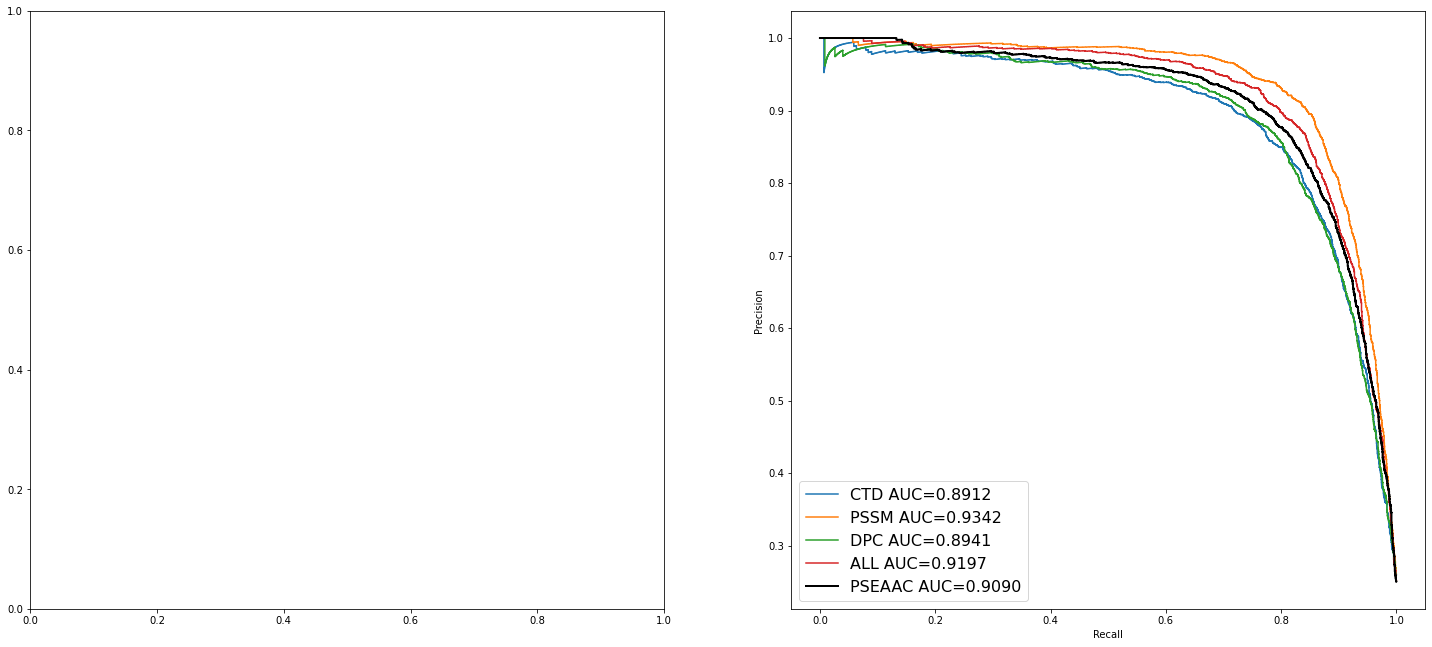

In [181]:
##CURVES

f, axes = plt.subplots(1, 2, figsize=(25, 11))

precision, recall, _ = precision_recall_curve(y_real_ctd, y_proba_ctd)
lab = 'CTD AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab)
precision, recall, _ = precision_recall_curve(y_real_pssm, y_proba_pssm)
lab = 'PSSM AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab)
precision, recall, _ = precision_recall_curve(y_real_dpc, y_proba_dpc)
lab = 'DPC AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab)
precision, recall, _ = precision_recall_curve(y_real_all, y_proba_all)
lab = 'ALL AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
lab = 'PSEAAC AUC=%.4f' % (auc(recall, precision))
axes[1].step(recall, precision, label=lab, lw=2, color='black')

axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].legend(loc='lower left', fontsize="16")